# Transfer Learning with TensorFlow Part 2: Fine-Tuning

In the previous notebookm we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

In [1]:
# Check if we're using GPU
!nvidia-smi

Sat Oct  7 01:03:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-07 01:03:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-07 01:03:51 (78.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're goingo to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications



In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2023-10-07 01:04:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.0MB/s    in 8.5s    

2023-10-07 01:04:10 (18.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [6]:
# Create trainin and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE=(224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  ...

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in Sequential order.

But the functional API gives us more flexibility with our models -https://www.tensorflow.org/guide/keras/functional_api

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the autputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePoolin2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])

24274472/24274472 [==============================] - 2s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePoolin2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20231007-010430
Epoch 1/5
24/24 [==============================] - 22s 263ms/step - loss: 1.8602 - accuracy: 0.4293 - val_loss: 1.3300 - val_accuracy: 0.7253
Epoch 2/5
24/24 [==============================] - 3s 124ms/step - loss: 1.1337 - accuracy: 0.7653 - val_loss: 0.9055 - val_accuracy: 0.8010
Epoch 3/5
24/24 [==============================] - 3s 131ms/step - loss: 0.8413 - accuracy: 0.7987 - val_loss: 0.7444 - val_accuracy: 0.8224
Epoch 4/5
24/24 [==============================] - 3s 123ms/step - loss: 0.6853 - accuracy: 0.8467 - val_loss: 0.6424 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 3s 124ms/step - loss: 0.5958 - accuracy: 0.8600 - val_loss: 0.5901 - val_accuracy: 0.8536


In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.5711 - accuracy: 0.8588


[0.5711407661437988, 0.8587999939918518]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [14]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [15]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

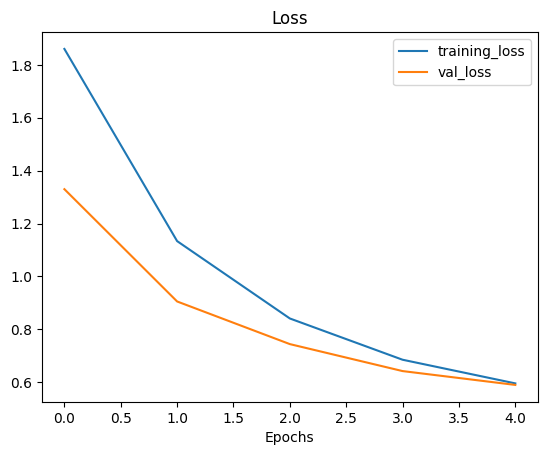

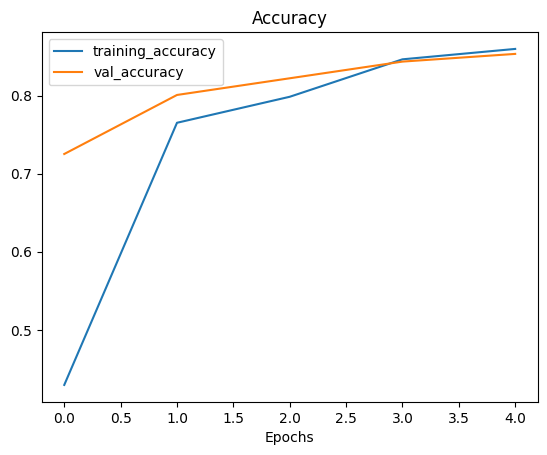

In [16]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demostrate the Global Average 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7 1280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePoolin2D

In [17]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])



<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

🔑**Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens in pretrained model outputs a feature vector (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of for our own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer leanring can get with only 105 of the training data, but how does it go with 1% of the training data ... How about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with dataaugmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation.
3. `model_3` - use fine-tuning trasfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑 **Note:** throughout all experiments the same test dataset will be used to evaluate our model .. this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [19]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-10-07 01:05:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  21.7MB/s    in 7.1s    

2023-10-07 01:05:28 (18.0 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'

In [22]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)   #default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`
We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather then the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [23]:
print(tf.__version__)

2.13.0


In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255)   # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

(-0.5, 470.5, 313.5, -0.5)

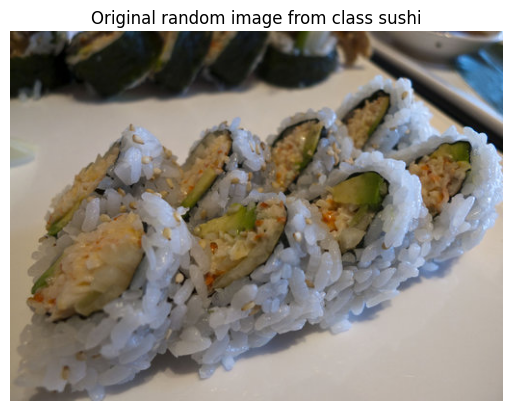

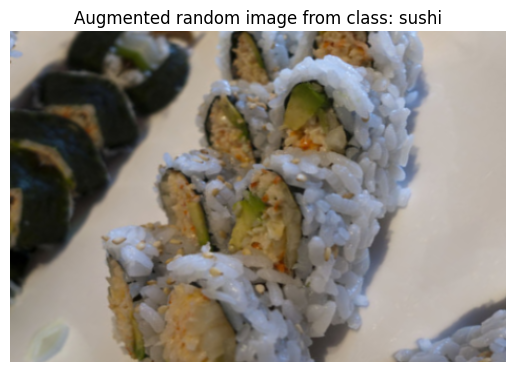

In [25]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);


# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

In [26]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [27]:
# Setup input shape and base mode, freezing the base model layers

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

16705208/16705208 [==============================] - 2s 0us/step
Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20231007-010538
Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.2619 - accuracy: 0.1286 - val_loss: 2.1424 - val_accuracy: 0.2303
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.0136 - accuracy: 0.2429 - val_loss: 2.0099 - val_accuracy: 0.3257
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.8698 - accuracy: 0.4857 - val_loss: 1.9002 - val_accuracy: 0.4095
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.6936 - accuracy: 0.6000 - val_loss: 1.7989 - val_accuracy: 0.4934
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5385 - accuracy: 0.8143 - val_loss: 1.7019 - val_accuracy: 0.5444


In [28]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [29]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 71ms/step - loss: 1.7379 - accuracy: 0.5316


[1.7378685474395752, 0.5315999984741211]

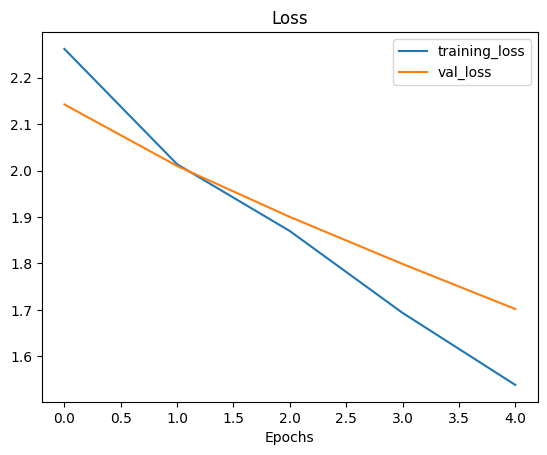

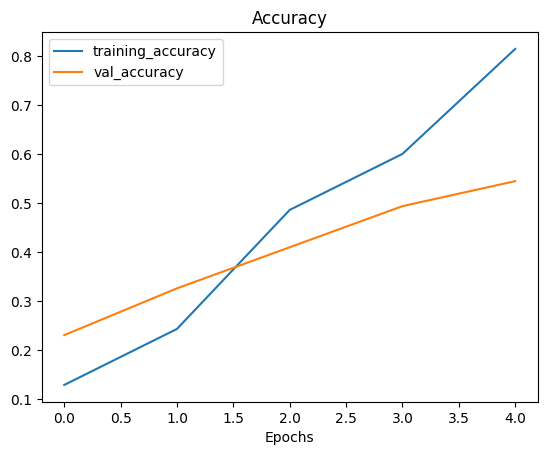

In [30]:
# How does the model with 1% of the and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

# Model 2: feature extraction transfer learning model with 10% of data augmentation

In [31]:
# Get 10% of data ...
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data(10_food_classes_10_percent)

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [32]:
# How many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [33]:
# set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [34]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255)   # if you're using a modelsuch as resNet50V2, you'll need to rescale your data, efficientnet has rescaling built-in
], name="data_augmentation")

# Setup the input shape to our model
input_shape=(224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name = "input_layer")
x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated
#https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [35]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_2D   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full modle or just the weights) durin training. This is useful so we can come and start where we left off.

In [36]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",     # save every epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [37]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_dat_aug = model_2.fit(train_data_10_percent,
                                         epochs=initial_epochs,
                                         validation_data=test_data,
                                         validation_steps=int(0.25 * len(test_data)),
                                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="10_percent_data_aug"),
                                                    checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20231007-010631
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0041 - accuracy: 0.3627
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 24s 725ms/step - loss: 2.0041 - accuracy: 0.3627 - val_loss: 1.4518 - val_accuracy: 0.6891
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3275 - accuracy: 0.6747
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 482ms/step - loss: 1.3275 - accuracy: 0.6747 - val_loss: 0.9822 - val_accuracy: 0.8141
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9872 - accuracy: 0.7733
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 530ms/step - loss: 0.9872 - accuracy: 0.7733 - val_loss: 0.7848 - val_accuracy: 0.8224
E

In [38]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 6s 61ms/step - loss: 0.5711 - accuracy: 0.8588


[0.5711406469345093, 0.8587999939918518]

In [39]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 68ms/step - loss: 0.6218 - accuracy: 0.8468


[0.6217599511146545, 0.8468000292778015]

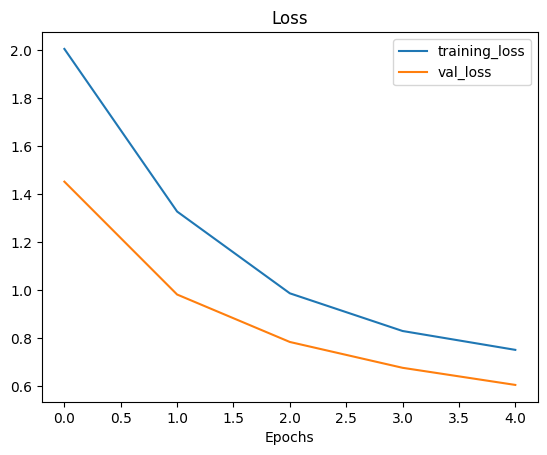

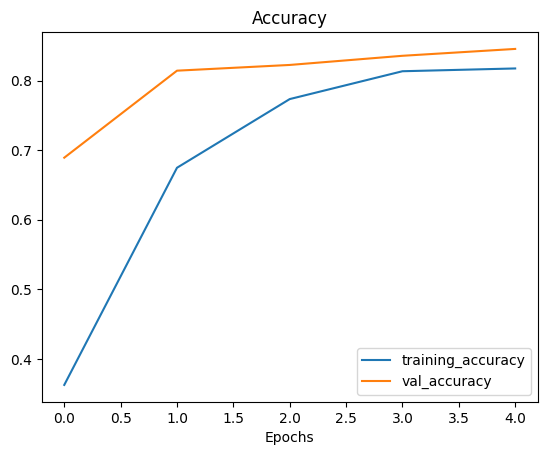

In [40]:
# Plot model loss curves
plot_loss_curves(history_10_percent_dat_aug)


### Loading in checkpointed weights

Loading in checkpointed weight returns a model to a specific checkpoint

In [41]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [42]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 77ms/step - loss: 0.6218 - accuracy: 0.8468


In [43]:
# If the results from our previously evaluated model_2 match the loaded weights , everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [44]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [45]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[2.38418579e-07 0.00000000e+00]


## Model 3: Fine-tunning an existing model on 10% of the data
🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [46]:
# Layers in loaded model
model_2.layers

In [47]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x785bb8d33640> True
<keras.src.engine.sequential.Sequential object at 0x785bbce31960> True
<keras.src.engine.functional.Functional object at 0x785bb873add0> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x785bb86fe050> True
<keras.src.layers.core.dense.Dense object at 0x785bb86ec970> True


In [48]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [49]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [50]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable=False

In [51]:
# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),  # when fine-tuning you typically want to lower the learning rate by 10x*
                metrics=["accuracy"])

>🔑**Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values).
A good resource for information on this is the ULMFit Paper: https://arxiv.org/abs/1801.06146

In [52]:
# Check wich layers are tunable (trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [53]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [54]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_dat_aug.epoch[-1],  # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")] )

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20231007-010812
Epoch 5/10
24/24 [==============================] - 24s 549ms/step - loss: 0.7457 - accuracy: 0.7547 - val_loss: 0.4415 - val_accuracy: 0.8553
Epoch 6/10
24/24 [==============================] - 10s 426ms/step - loss: 0.3345 - accuracy: 0.8920 - val_loss: 0.4429 - val_accuracy: 0.8602
Epoch 7/10
24/24 [==============================] - 11s 437ms/step - loss: 0.2159 - accuracy: 0.9347 - val_loss: 0.5119 - val_accuracy: 0.8421
Epoch 8/10
24/24 [==============================] - 10s 419ms/step - loss: 0.1419 - accuracy: 0.9520 - val_loss: 0.4998 - val_accuracy: 0.8454
Epoch 9/10
24/24 [==============================] - 10s 391ms/step - loss: 0.1103 - accuracy: 0.9667 - val_loss: 0.4281 - val_accuracy: 0.8684
Epoch 10/10
24/24 [==============================] - 11s 447ms/step - loss: 0.0789 - accuracy: 0.9773 - val_loss: 0.4819 - val_accuracy: 0.8569


In [55]:
# evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
result_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.5135 - accuracy: 0.8548


In [56]:
results_10_percent_data_aug

[0.6217599511146545, 0.8468000292778015]

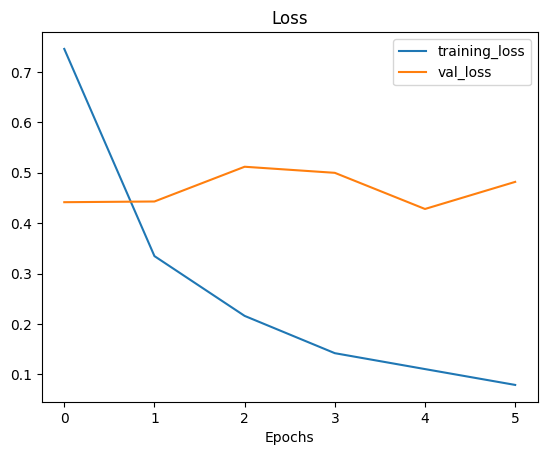

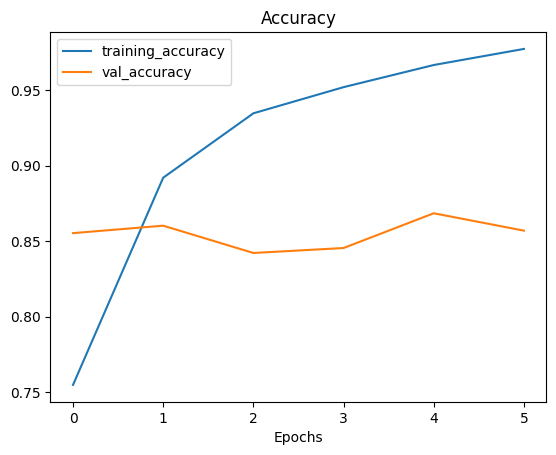

In [57]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tunning)

In [58]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow history objects.
  """
  # Get original historymeasurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

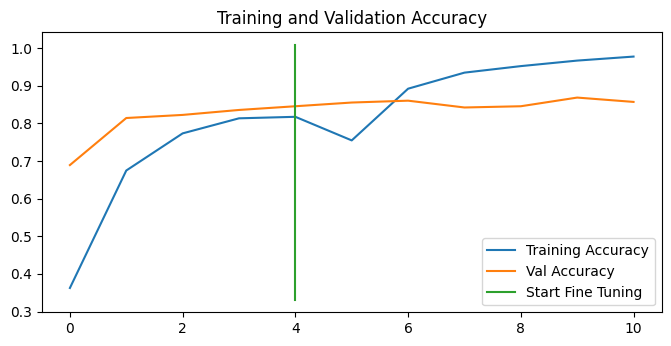

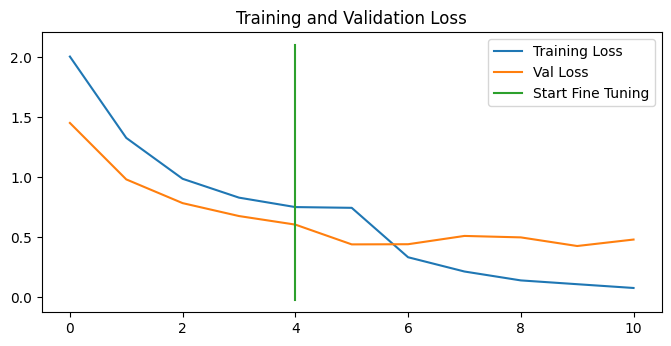

In [59]:
compare_historys(history_10_percent_dat_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine-tuning and existing model on all of the data


In [60]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")


--2023-10-07 01:09:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  19.9MB/s    in 25s     

2023-10-07 01:10:11 (19.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [61]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [62]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 

In [63]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [64]:
# Evaluate model 2 (this is the fine-tune on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 75ms/step - loss: 0.5135 - accuracy: 0.8548


[0.5135306715965271, 0.8547999858856201]

In [65]:
result_fine_tune_10_percent

[0.5135306715965271, 0.8547999858856201]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
# Load weights from checkpoint, that way we can fine-tune from
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [67]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.6218 - accuracy: 0.8468


[0.6217597723007202, 0.8468000292778015]

In [68]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6217599511146545, 0.8468000292778015]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tune the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step2 except this time we're going to use all of the data (model_4).

In [69]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [70]:
# Let's drill into our base_model (efficientnet) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)



0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [71]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])


In [72]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_dat_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20231007-011218
Epoch 5/10
235/235 [==============================] - 80s 301ms/step - loss: 0.6237 - accuracy: 0.8005 - val_loss: 0.3048 - val_accuracy: 0.8947
Epoch 6/10
235/235 [==============================] - 60s 252ms/step - loss: 0.4235 - accuracy: 0.8628 - val_loss: 0.2881 - val_accuracy: 0.9030
Epoch 7/10
235/235 [==============================] - 53s 222ms/step - loss: 0.3524 - accuracy: 0.8840 - val_loss: 0.3161 - val_accuracy: 0.8914
Epoch 8/10
235/235 [==============================] - 49s 207ms/step - loss: 0.2768 - accuracy: 0.9105 - val_loss: 0.2670 - val_accuracy: 0.9112
Epoch 9/10
235/235 [==============================] - 45s 191ms/step - loss: 0.2388 - accuracy: 0.9181 - val_loss: 0.3034 - val_accuracy: 0.9030
Epoch 10/10
235/235 [==============================] - 45s 188ms/step - loss: 0.2146 - accuracy: 0.9299 - val_loss: 0.2643 - val_accuracy: 0.9128


In [73]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 69ms/step - loss: 0.2719 - accuracy: 0.9124


[0.27186647057533264, 0.9124000072479248]

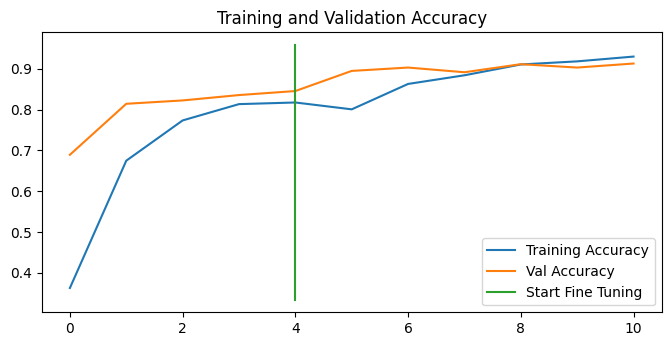

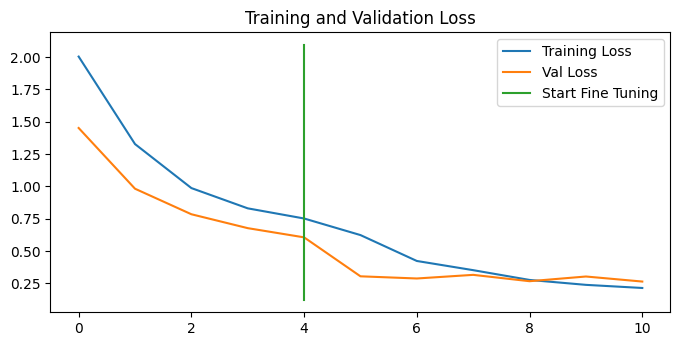

In [74]:
# How did fine-tuning fo with more data:
compare_historys(original_history=history_10_percent_dat_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

>🔑 **Note:** Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should -4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning experiments with 10 Food101 Classes"\
  --description "A seies of different transfer learning experiments with varying amounts of data and fine-tuning."\
  --one_shot # exits the uploader once its finished uploading

2023-10-07 01:18:02.705536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 

My TensorBoard experiments are available at:

In [ ]:
# View all of your uploaded TensorBoard.dev experiments (public)
!tensorboard dev list

In [ ]:
# To delete an experiment
# !tensorboard dev delete --experiment_id